## TITLE: ADDA LSTM
### AUTHOR: Harrison Myers
### DATE: 2025-04-18
##### DESCRIPTION: Trains and makes predictions from a Adversarial Discriminative Domain Adaptation LSTM network for transfer learning predictions of floodplain DO


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math, keras, random
from keras import layers, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from statsmodels.tsa.api import SimpleExpSmoothing
from keras.callbacks import EarlyStopping
from datetime import datetime
import hydroeval as he
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-04-22 20:41:50.422711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 20:41:50.855881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 20:41:51.064232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 20:41:51.111810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 20:41:51.378431: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os

# Back out one directory to project folder
PROJECT_DIR = os.path.dirname(os.path.abspath(''))
os.chdir(PROJECT_DIR)

# Set directories
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIGURE_DIR = os.path.join(PROJECT_DIR, 'outputs','figures')
OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
CONFIG_DIR = os.path.join(PROJECT_DIR, "config")

# Setup logging
from src.utils.logging_setup import setup_logging
logger = setup_logging(log_dir='logs', log_filename="ADDA_LSTM.log")

In [3]:
print(PROJECT_DIR)

/mnt/c/Users/ghmyers/OneDrive - University of Vermont/Documents/UVM/Research/PhD/FloodplainDOPrediction


In [4]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1745368916.126229  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745368916.341308  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745368916.341376  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
# Run data preprocessing pipelines
from scripts.data_preprocessing import ADDA_pipeline, floodplain_pipeline
adda_dict = ADDA_pipeline('4')
floodplain_dict = floodplain_pipeline('4')

['lat', 'FUNGICIDE', 'ELEV_MEAN', 'LAKEPOND', 'N97', 'CNPY11_BUFF100', 'BASIN_AREA', 'NLCD01_52', 'ELEV_MAX', 'dayl (s)', 'HGAD', 'prcp (mm/day)', 'STRM_DENS', 'WDANN', 'q', 'o', 'NLCD01_81', 'ELEV_MIN', 'HGC', 'CONTACT', 'BEDPERM_6', 'RH', 'swe (kg/m2)', 'NLCD01_95', 'tmin (degrees C)', 'BFI', 'srad (W/m2)', 'SALINAVE', 'ARTIFICIAL', 'SANDAVE', 'sinuosity', 'temp', 'vp (Pa)', 'tmax (degrees C)', 'SILTAVE', 'lon']
['lat', 'FUNGICIDE', 'ELEV_MEAN', 'LAKEPOND', 'N97', 'CNPY11_BUFF100', 'BASIN_AREA', 'NLCD01_52', 'ELEV_MAX', 'dayl (s)', 'HGAD', 'prcp (mm/day)', 'STRM_DENS', 'WDANN', 'q', 'o', 'NLCD01_81', 'ELEV_MIN', 'HGC', 'CONTACT', 'BEDPERM_6', 'RH', 'swe (kg/m2)', 'NLCD01_95', 'tmin (degrees C)', 'BFI', 'srad (W/m2)', 'SALINAVE', 'ARTIFICIAL', 'SANDAVE', 'sinuosity', 'temp', 'vp (Pa)', 'tmax (degrees C)', 'SILTAVE', 'lon']
1145272
285197
['lat', 'FUNGICIDE', 'ELEV_MEAN', 'LAKEPOND', 'N97', 'CNPY11_BUFF100', 'BASIN_AREA', 'NLCD01_52', 'ELEV_MAX', 'dayl (s)', 'HGAD', 'prcp (mm/day)', 'S

In [6]:
# Get ADDA training and testing data, and data generators
X_train = adda_dict['X_train']
X_test = adda_dict['X_test']
y_train = adda_dict['y_train']
y_test = adda_dict['y_test']
train_gen = adda_dict['train_gen']
test_gen = adda_dict['test_gen']
steps_per_epoch = adda_dict['steps_per_epoch']
val_steps = adda_dict['val_steps']

In [7]:
# Get hyperparameters from config file
import yaml
CONFIG_DIR = os.path.join(PROJECT_DIR, 'config')
with open(os.path.join(CONFIG_DIR, 'adda_lstm4_config.yaml'), 'r') as f:
    config = yaml.safe_load(f)
    
seed = config['seed']
split_pct = config['split_pct']
window_length = config['window_length']
hidden_layers = config['hidden_layers']
hidden_units = config['hidden_units']
batch_size = config['batch_size']
n_epochs = config['n_epochs']
activation_dense = config['activation_dense']
learning_rate = config['learning_rate']
dropout = config['dropout']
stop_patience = config['stop_patience']
lr_schedule_patience = config['lr_schedule_patience']
n_features = len(X_train.columns)

In [8]:
from src.utils import model_building_training_functions as mbf
# Build the model
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
adda_model = mbf.build_adversarial_model(1, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, batch_norm=False)

I0000 00:00:1745369062.151109  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745369062.151264  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745369062.151288  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745369063.583635  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745369063.583759  639916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-22

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 7, 35)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 8)         │      1,408 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8)         │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gradient_reversal   │ (None, 8)         │          0 │ dropout[0][0]     │
│ (GradientReversal)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         72 │ gradient_reversa… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ do_output (Dense)   │ (None, 1)         │          9 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ domain_output       │ (None, 1)         │          9 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,498 (5.85 KB)

 Trainable params: 1,498 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train model
keras.utils.set_random_seed(seed)
model_name = 'ADDA_LSTM'
earlyStopping = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=lr_schedule_patience, min_lr=0.0000001, verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(PROJECT_DIR,'models', f'{model_name}.weights.h5'), save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

callbacks = [earlyStopping, lr_scheduler, checkpoint_callback]
history = adda_model.fit(train_gen, steps_per_epoch=steps_per_epoch, batch_size=batch_size, 
                    epochs=n_epochs, verbose=1, validation_data=test_gen, 
                    validation_steps=val_steps, callbacks=callbacks)
logger.info(f'Model ({model_name}) parameters:')
logger.info(f'Seed: {seed}')
logger.info(f'Activation: {activation_dense}')
logger.info(f'Split Percentage: {split_pct}')
logger.info(f'Hidden LSTM layers: {hidden_layers}')
logger.info(f'Hidden units: {hidden_units}')
logger.info(f'Window length: {window_length}')
logger.info(f'Batch size: {batch_size}')
logger.info(f'Learning rate: {learning_rate}')
logger.info(f'Dropout: {dropout}')
logger.info(f'Epochs: {n_epochs}')
logger.info(f'Stop patience: {stop_patience}')
logger.info(f"Learning rate scheduler patience: {lr_schedule_patience}")
logger.info("Custom loss function: None")
logger.info(f"Model loss: {history.history['do_output_loss']}")
logger.info(f"Validation loss: {history.history['val_do_output_loss']}")
logger.info(f"Adversarial loss: {history.history['domain_output_loss']}")
logger.info(f"Validation adversarial loss: {history.history['val_domain_output_loss']}")

Epoch 1/150


2025-04-22 20:44:29.955602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


4473/4473 ━━━━━━━━━━━━━━━━━━━━ 423s 94ms/step - do_output_kge_metric: 0.0894 - do_output_loss: 0.0772 - do_output_percent_bias: 13.9822 - do_output_r2_score: -1.3233 - do_output_root_mean_squared_error: 0.2728 - domain_output_accuracy: 0.7922 - domain_output_loss: 0.2190 - loss: 0.2962 - val_do_output_kge_metric: 0.4295 - val_do_output_loss: 0.0200 - val_do_output_percent_bias: 3.0192 - val_do_output_r2_score: 0.3660 - val_do_output_root_mean_squared_error: 0.1413 - val_domain_output_accuracy: 0.7969 - val_domain_output_loss: 0.1838 - val_loss: 0.2038 - learning_rate: 8.0000e-05
Epoch 2/150
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 415s 93ms/step - do_output_kge_metric: 0.4750 - do_output_loss: 0.0237 - do_output_percent_bias: 2.2476 - do_output_r2_score: 0.2841 - do_output_root_mean_squared_error: 0.1540 - domain_output_accuracy: 0.7969 - domain_output_loss: 0.1838 - loss: 0.2075 - val_do_output_kge_metric: 0.5098 - val_do_output_loss: 0.0163 - val_do_output_percent_bias: 0.7305 - val_do_output_

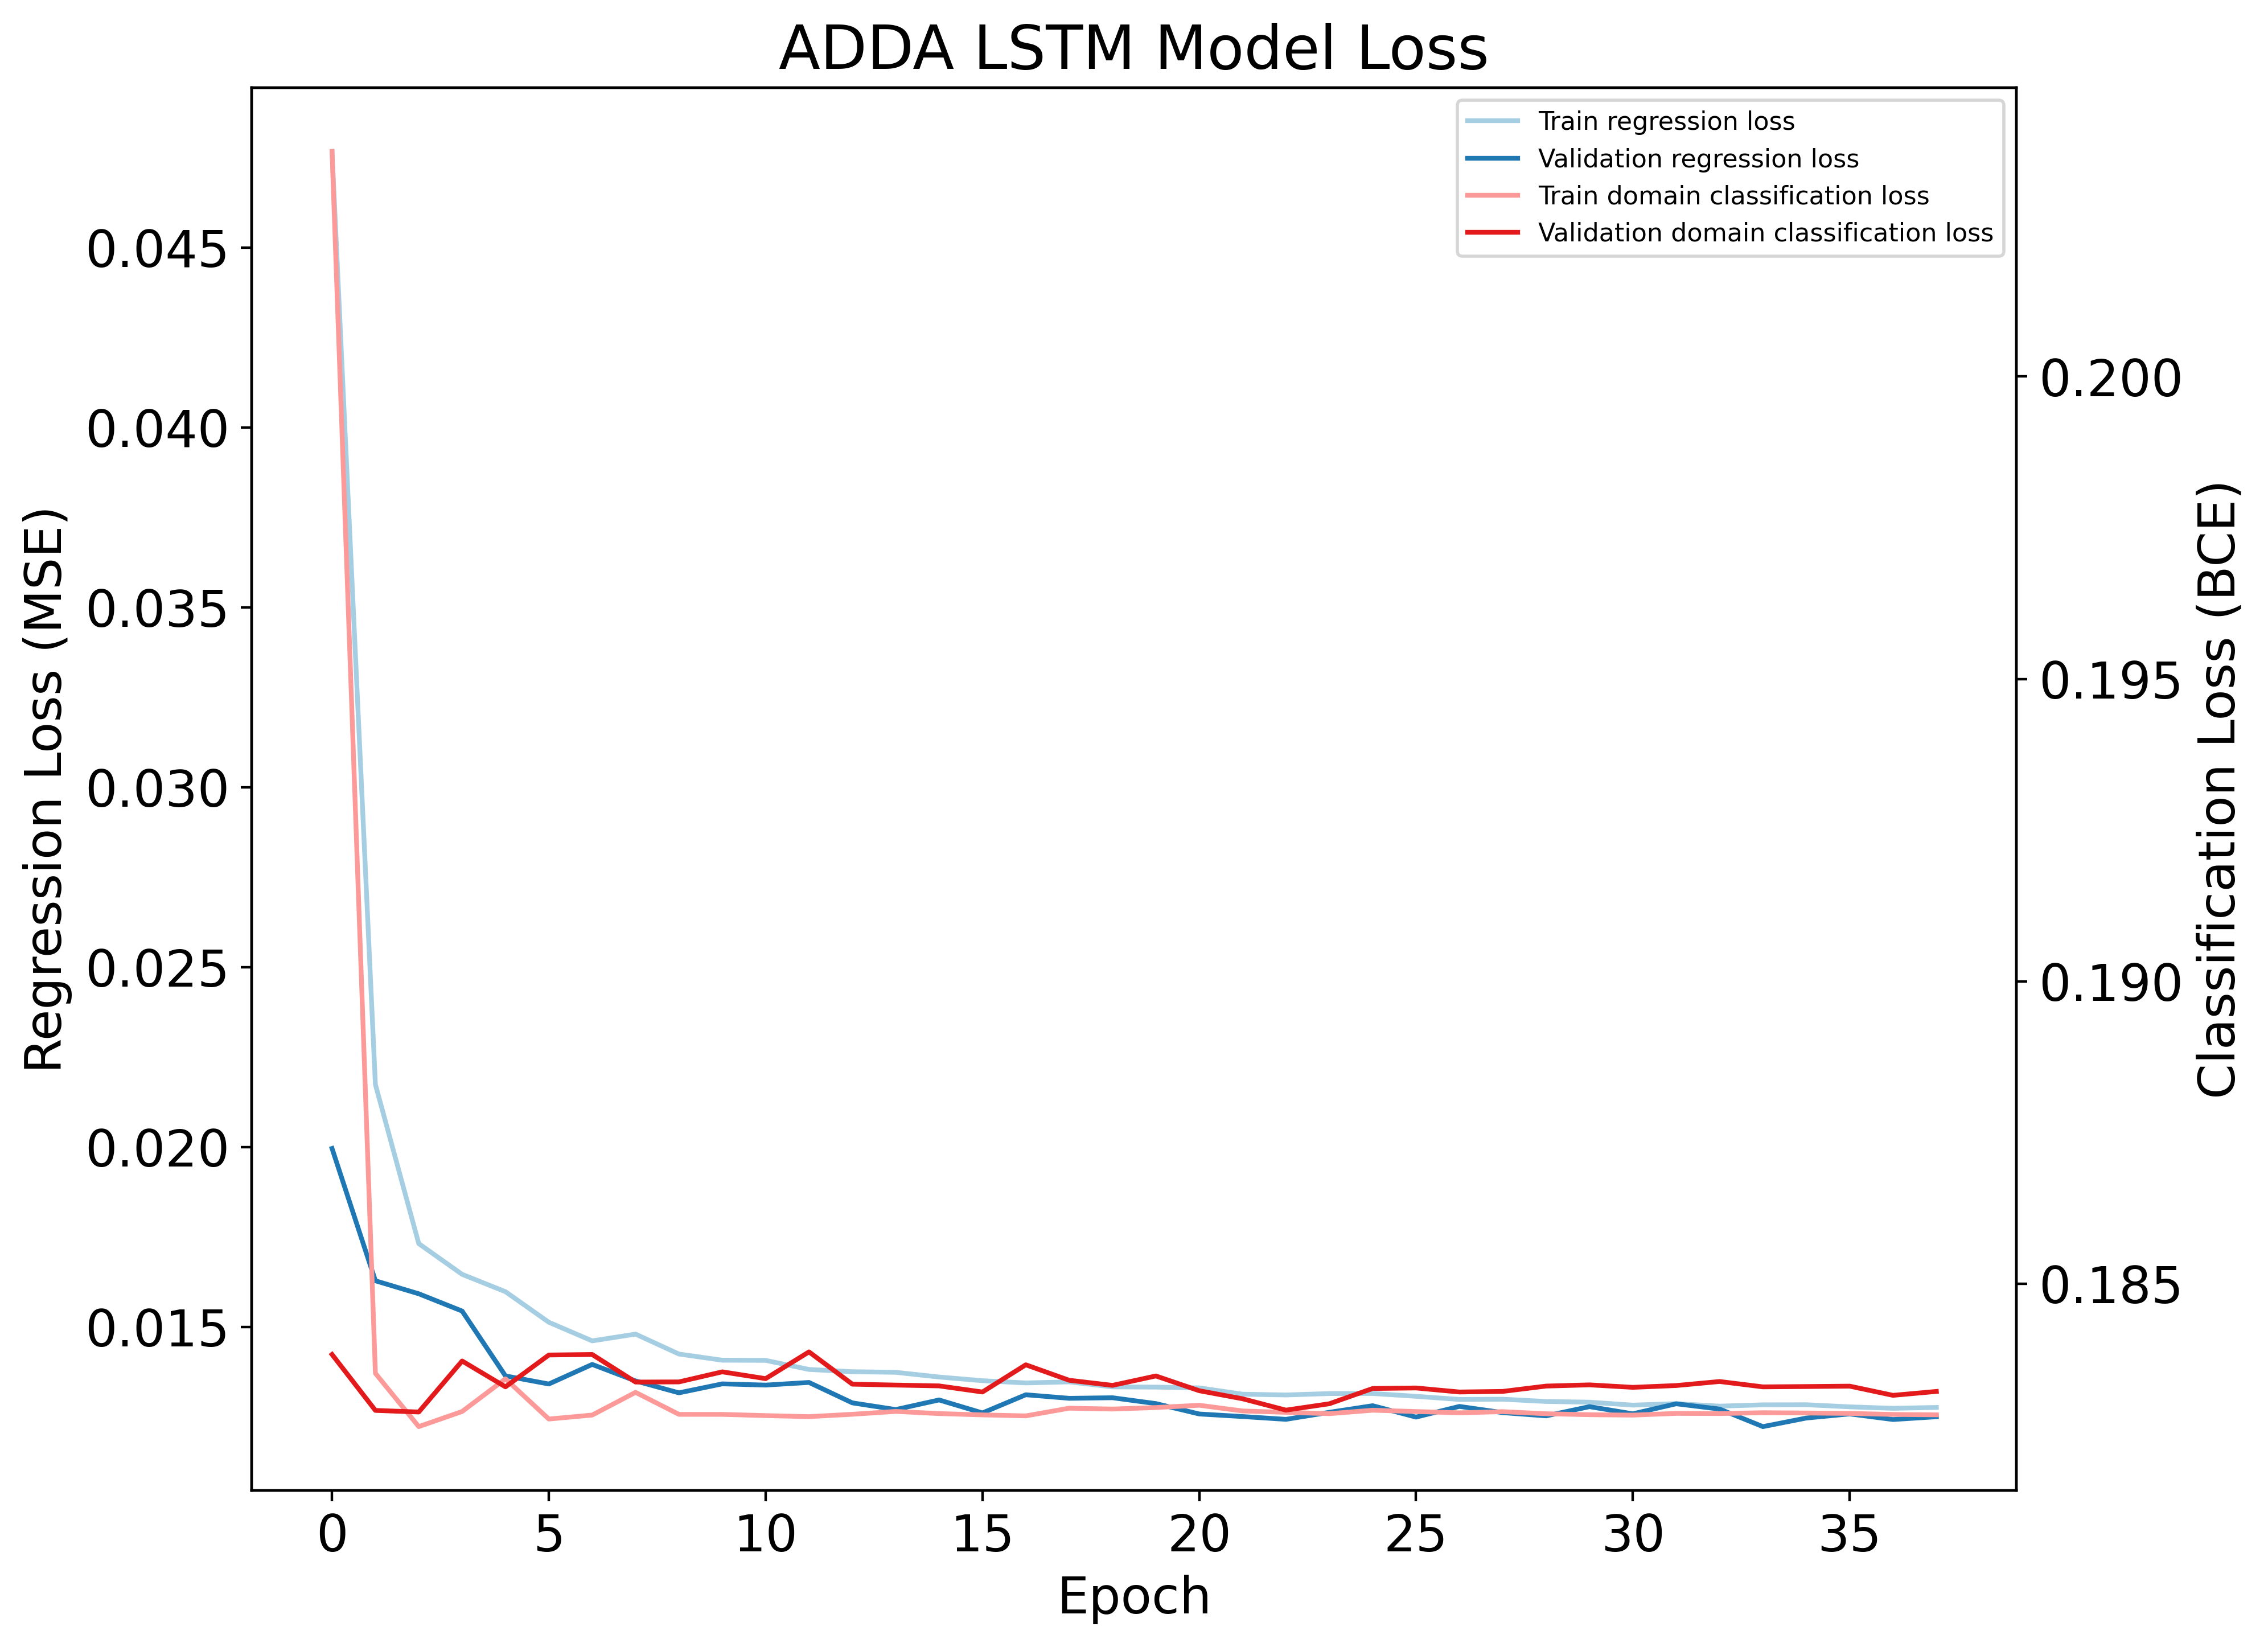

In [30]:
cmap = plt.get_cmap('Paired')
fig, ax1 = plt.subplots(figsize=(10,8), dpi=400)
ax1.plot(history.history['do_output_loss'], label="Train regression loss", color=cmap.colors[0])
ax1.plot(history.history['val_do_output_loss'], label="Validation regression loss", color=cmap.colors[1])
ax1.set_title('ADDA LSTM Model Loss')
ax1.set_ylabel('Regression Loss (MSE)')
ax1.set_xlabel('Epoch')
ax2 = ax1.twinx()
ax2.plot(history.history['domain_output_loss'], color=cmap.colors[4], label="Train domain classification loss")
ax2.plot(history.history['val_domain_output_loss'], color=cmap.colors[5], label="Validation domain classification loss")
ax2.set_ylabel('Classification Loss (BCE)')

fig.legend(loc="upper right", bbox_to_anchor=(1.0, 1.0), bbox_transform=ax1.transAxes, fontsize=8)
plt.savefig(os.path.join(FIGURE_DIR, 'ADDA_LSTM_loss.png'))

plt.show()

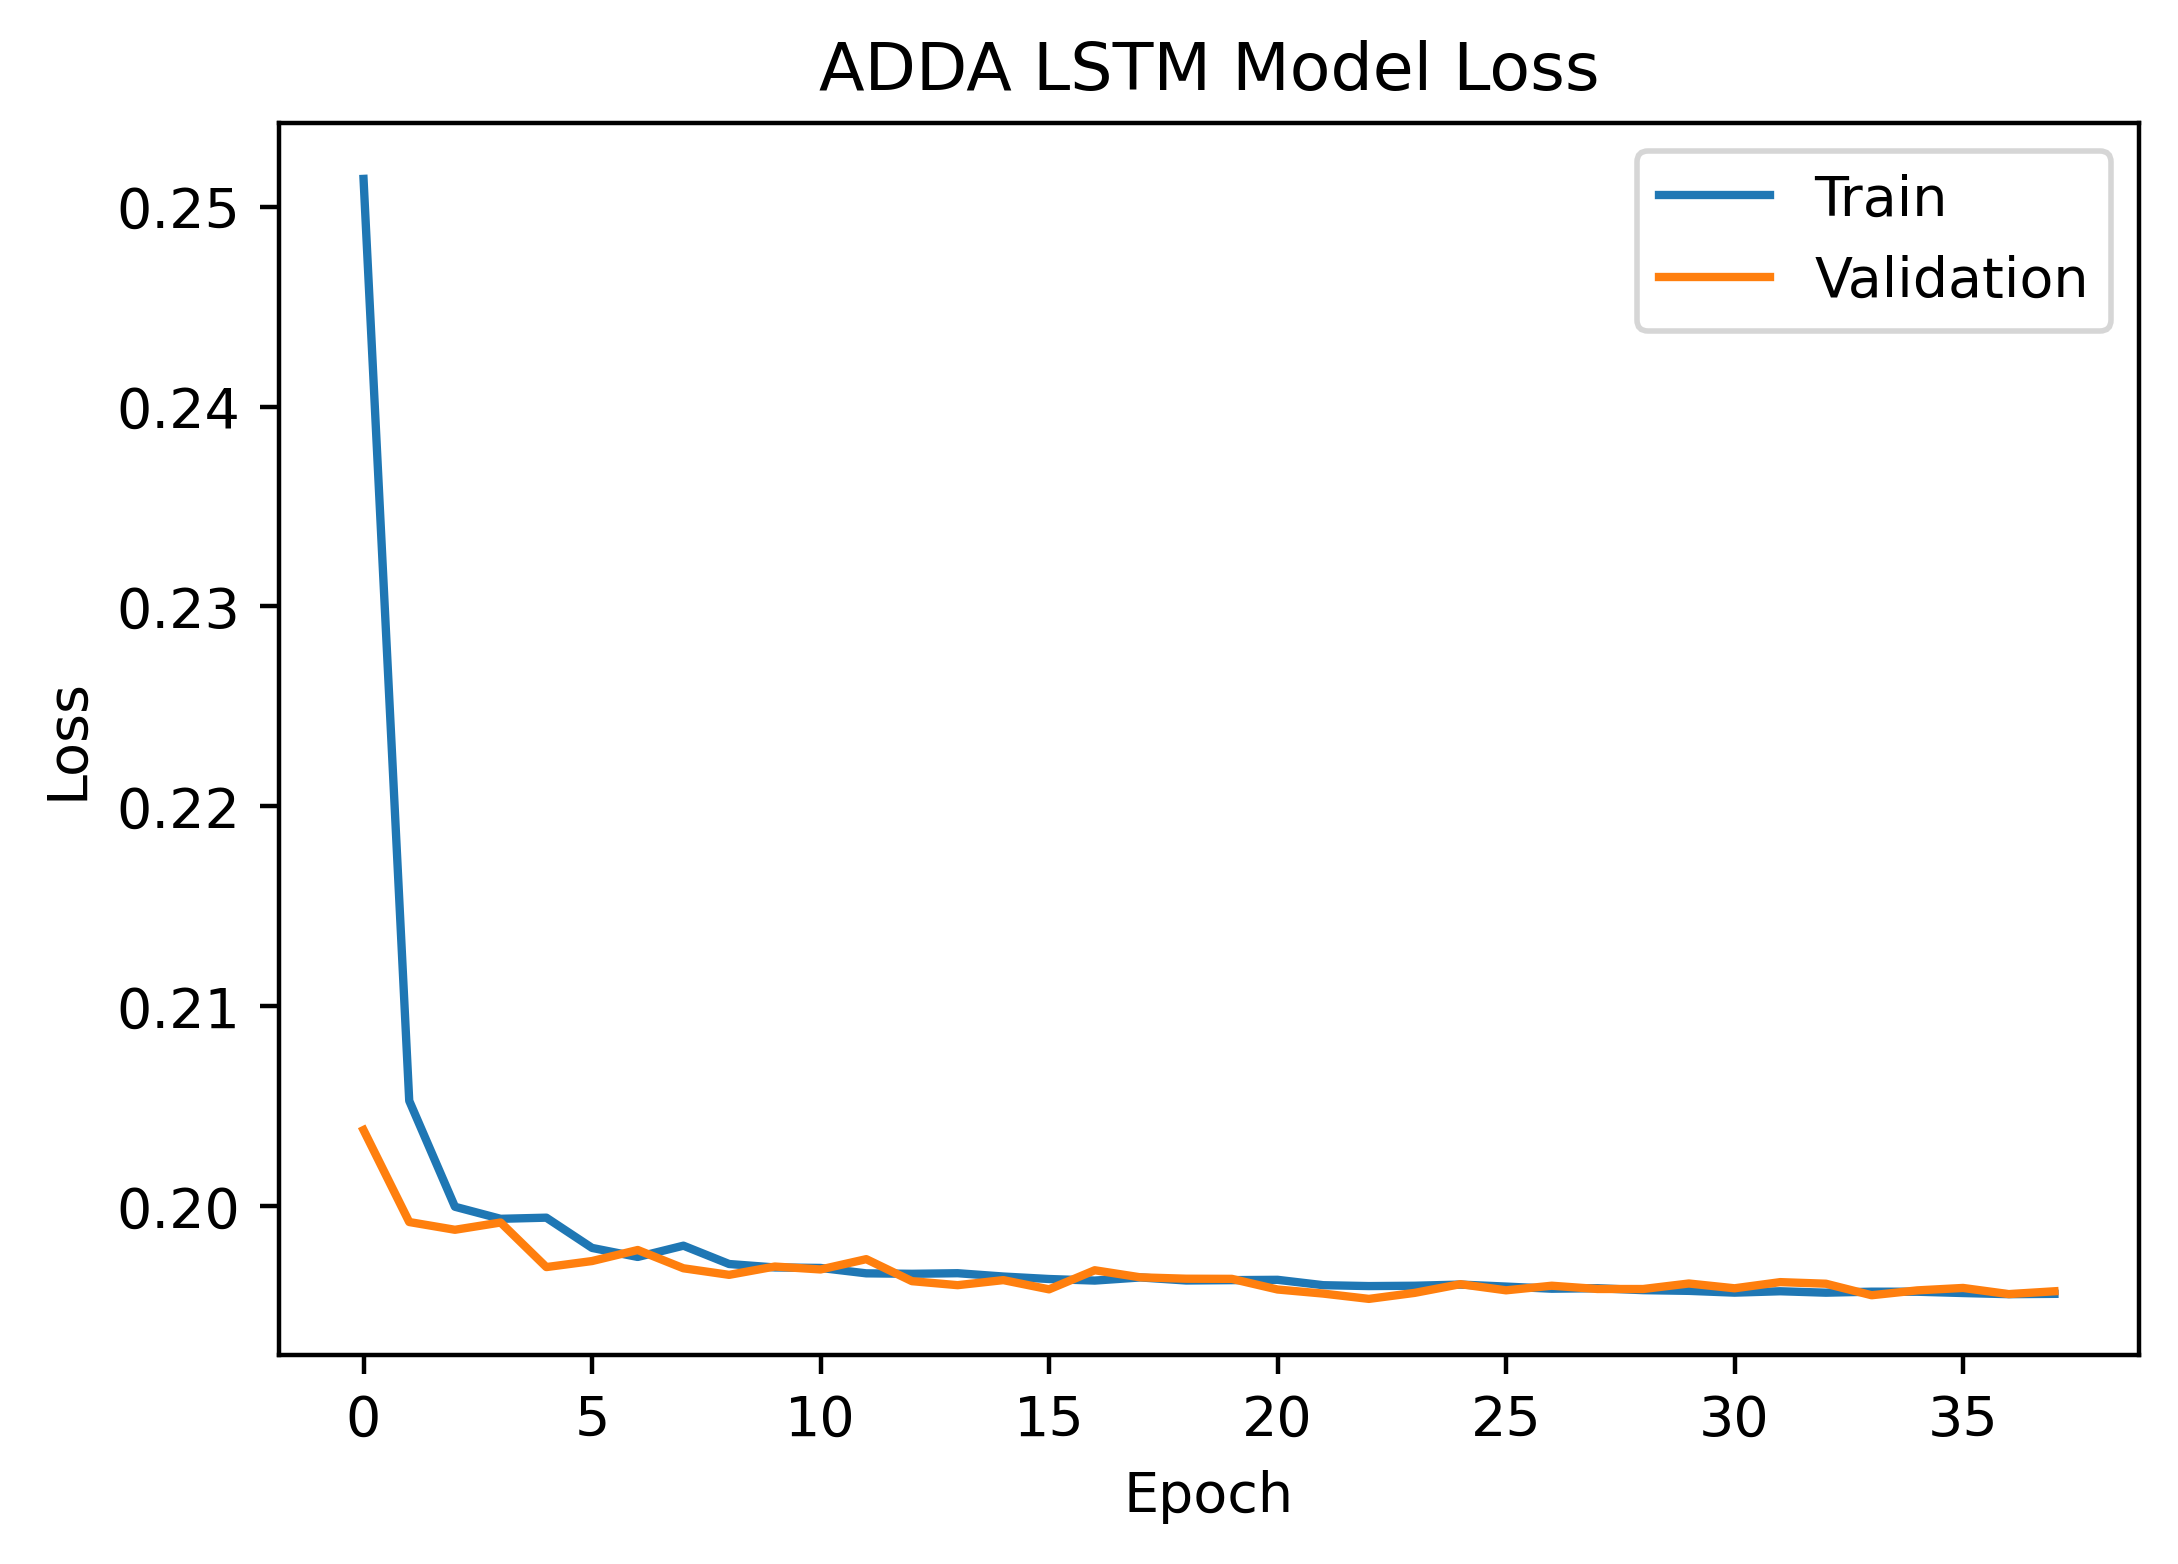

In [10]:
# Save Loss
plt.figure(figsize=(6,4), dpi=400)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ADDA LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(os.path.join(FIGURE_DIR, 'ADDA_LSTM_loss.png'))
plt.show()

In [11]:
# Build regression model that and load trained LSTM and regression head weights from adda model
adda_reg_model = mbf.build_regression_only_model(hidden_layers, hidden_units, window_length, n_features,
                                 dropout=dropout, mask=False, mask_val=-1, batch_norm=False,
                                 activation_dense="relu")

for reg_layer, adda_layer in zip(adda_reg_model.layers, adda_model.layers):
    if adda_layer.name in reg_layer.name:
        print(f"Copying weights from {adda_layer.name} to {reg_layer.name}")
        reg_layer.set_weights(adda_layer.get_weights())

Copying weights from input to input
Copying weights from lstm to lstm_1
Copying weights from dropout to dropout_1


In [12]:
# Get floodplain data for testing
# Extract necessary data from floodplain data dictionary
# Get master (i.e., concatenated across all sites) data 
X_train_FP = floodplain_dict['master']['X_train_fp']
y_train_FP = floodplain_dict['master']['y_train_fp']
X_test_FP= floodplain_dict['master']['X_test_fp']
y_test_FP = floodplain_dict['master']['y_test_fp']
train_gen_FP = floodplain_dict['master']['train_gen_fp']
test_gen_FP = floodplain_dict['master']['test_gen_fp']
steps_per_epoch_FP = floodplain_dict['master']['steps_per_epoch_fp']
val_steps_FP = floodplain_dict['master']['val_steps_fp']
X_FP_rs = floodplain_dict['master']['X_master_rs']
y_FP_rs = floodplain_dict['master']['y_master_rs']

# Get site level data
# OC2
OC2_noNA = floodplain_dict['OC2']['OC2_noNA']
X_OC2 = floodplain_dict['OC2']['X_OC2']
y_OC2 = floodplain_dict['OC2']['y_OC2']
OC2_start_ind = floodplain_dict['OC2']['OC2_start']
OC2_end_ind = floodplain_dict['OC2']['OC2_end']
# LF1
LF1_noNA = floodplain_dict['LF1']['LF1_noNA']
X_LF1 = floodplain_dict['LF1']['X_LF1']
y_LF1 = floodplain_dict['LF1']['y_LF1']
LF1_start_ind = floodplain_dict['LF1']['LF1_start']
LF1_end_ind = floodplain_dict['LF1']['LF1_end']
# LF2
LF2_noNA = floodplain_dict['LF2']['LF2_noNA']
X_LF2 = floodplain_dict['LF2']['X_LF2']
y_LF2 = floodplain_dict['LF2']['y_LF2']
LF2_start_ind = floodplain_dict['LF2']['LF2_start']
LF2_end_ind = floodplain_dict['LF2']['LF2_end']
# OC4
OC4_noNA = floodplain_dict['OC4']['OC4_noNA']
X_OC4 = floodplain_dict['OC4']['X_OC4']
y_OC4 = floodplain_dict['OC4']['y_OC4']
OC4_start_ind = floodplain_dict['OC4']['OC4_start']
OC4_end_ind = floodplain_dict['OC4']['OC4_end']
# LF3
LF3_noNA = floodplain_dict['LF3']['LF3_noNA']
X_LF3 = floodplain_dict['LF3']['X_LF3']
y_LF3 = floodplain_dict['LF3']['y_LF3']
LF3_start_ind = floodplain_dict['LF3']['LF3_start']
LF3_end_ind = floodplain_dict['LF3']['LF3_end']
# OC1
OC1_noNA = floodplain_dict['OC1']['OC1_noNA']
X_OC1 = floodplain_dict['OC1']['X_OC1']
y_OC1 = floodplain_dict['OC1']['y_OC1'] 
OC1_start_ind = floodplain_dict['OC1']['OC1_start']
OC1_end_ind = floodplain_dict['OC1']['OC1_end']
# OC3
OC3_noNA = floodplain_dict['OC3']['OC3_noNA']
X_OC3 = floodplain_dict['OC3']['X_OC3']
y_OC3 = floodplain_dict['OC3']['y_OC3']
OC3_start_ind = floodplain_dict['OC3']['OC3_start']
OC3_end_ind = floodplain_dict['OC3']['OC3_end']

In [13]:
OC2_start = OC2_noNA.index.get_loc(OC2_start_ind); OC2_end = OC2_noNA.index.get_loc(OC2_end_ind)
LF1_start = LF1_noNA.index.get_loc(LF1_start_ind); LF1_end = LF1_noNA.index.get_loc(LF1_end_ind)
LF2_start = LF2_noNA.index.get_loc(LF2_start_ind); LF2_end = LF2_noNA.index.get_loc(LF2_end_ind)
OC4_start = OC4_noNA.index.get_loc(OC4_start_ind); OC4_end = OC4_noNA.index.get_loc(OC4_end_ind)
LF3_start = LF3_noNA.index.get_loc(LF3_start_ind); LF3_end = LF3_noNA.index.get_loc(LF3_end_ind)
OC1_start = OC1_noNA.index.get_loc(OC1_start_ind); OC1_end = OC1_noNA.index.get_loc(OC1_end_ind)
OC3_start = OC3_noNA.index.get_loc(OC3_start_ind); OC3_end = OC3_noNA.index.get_loc(OC3_end_ind)

In [14]:
OC2_preds = adda_reg_model.predict(X_OC2, batch_size=batch_size)
LF1_preds = adda_reg_model.predict(X_LF1, batch_size=batch_size)
LF2_preds = adda_reg_model.predict(X_LF2, batch_size=batch_size)
OC4_preds = adda_reg_model.predict(X_OC4, batch_size=batch_size)
LF3_preds = adda_reg_model.predict(X_LF3, batch_size=batch_size)
OC1_preds = adda_reg_model.predict(X_OC1, batch_size=batch_size)
OC3_preds = adda_reg_model.predict(X_OC3, batch_size=batch_size)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [15]:
import joblib
scaler_y = joblib.load(os.path.join(MODEL_DIR, 'y_scaler_old.pkl'))
scaler = joblib.load(os.path.join(MODEL_DIR, 'scaler_old.pkl'))

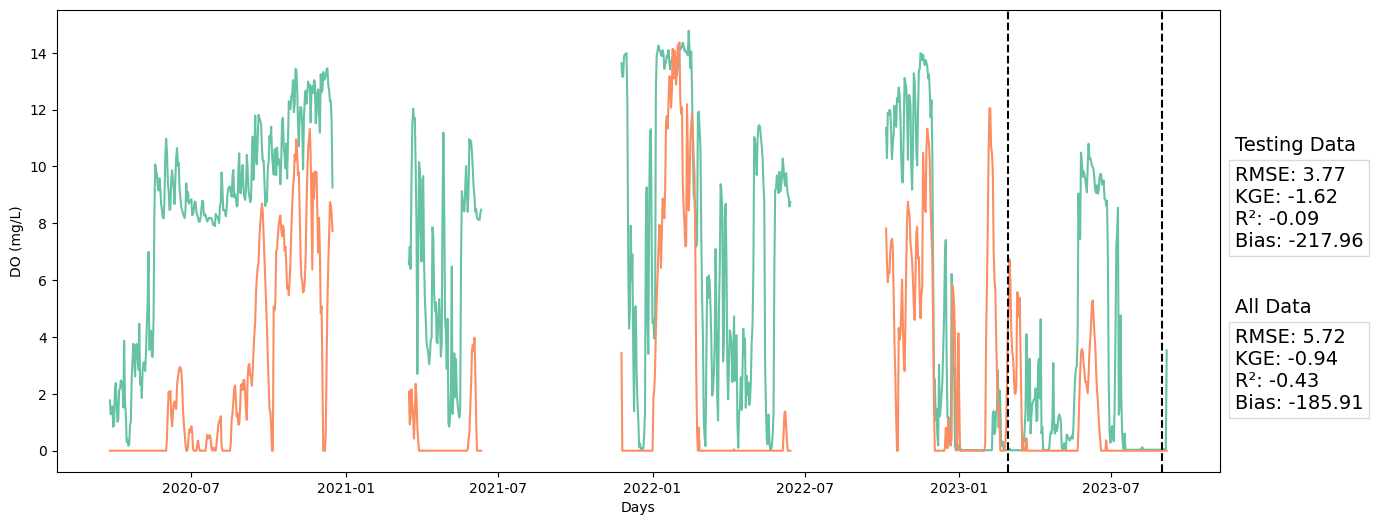

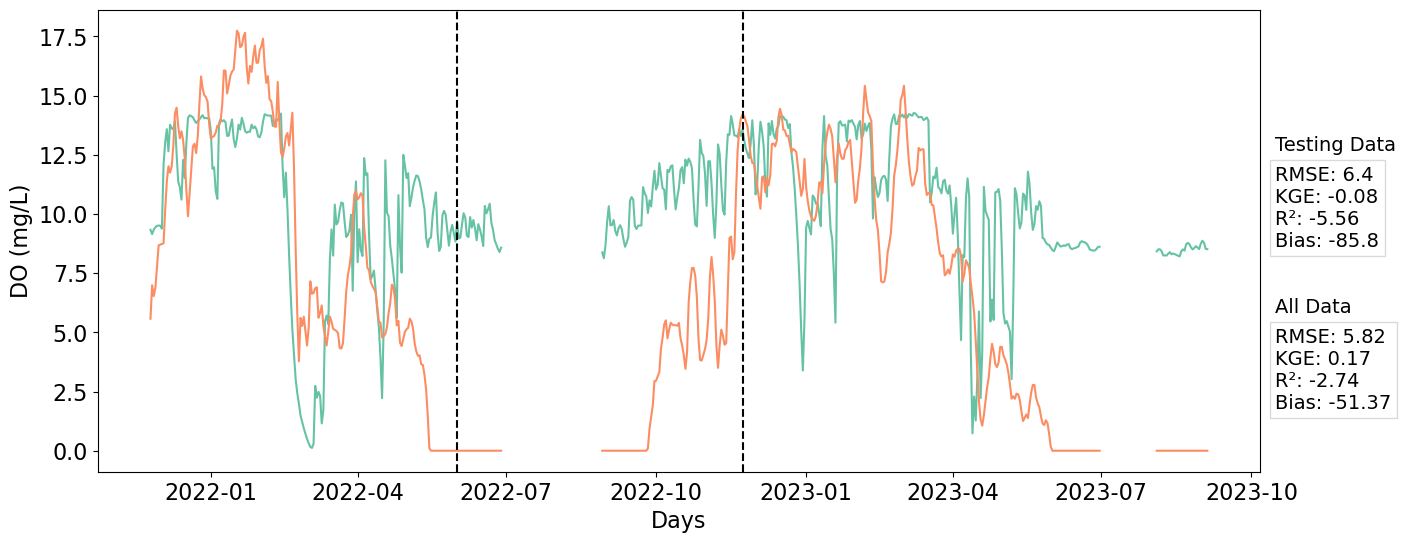

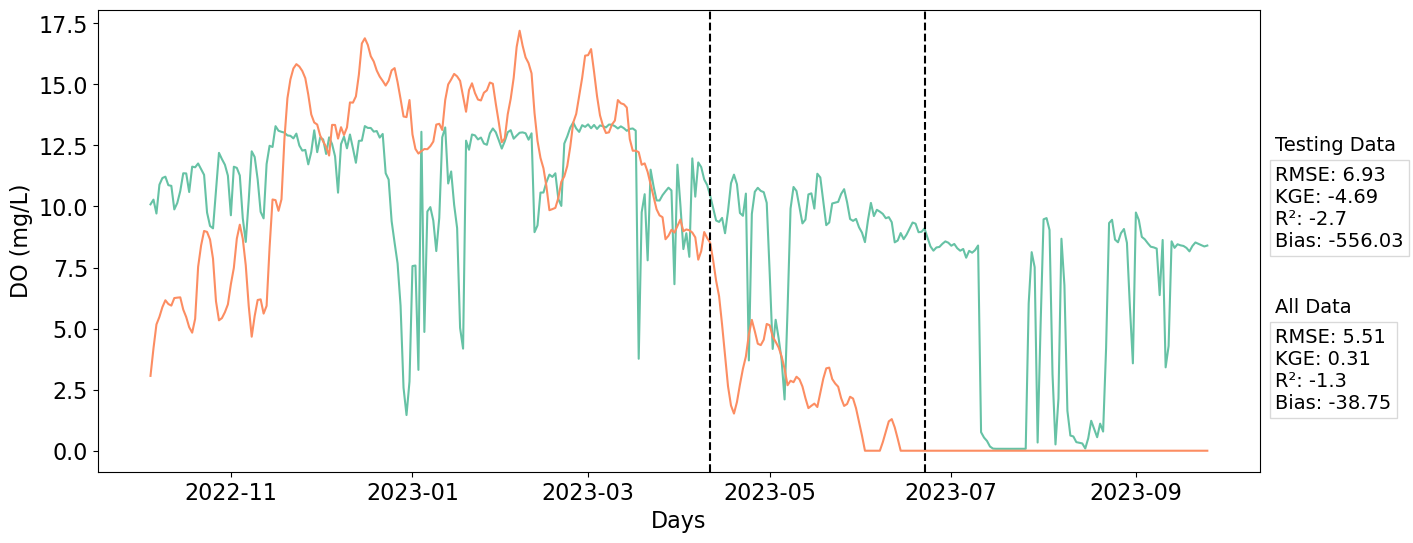

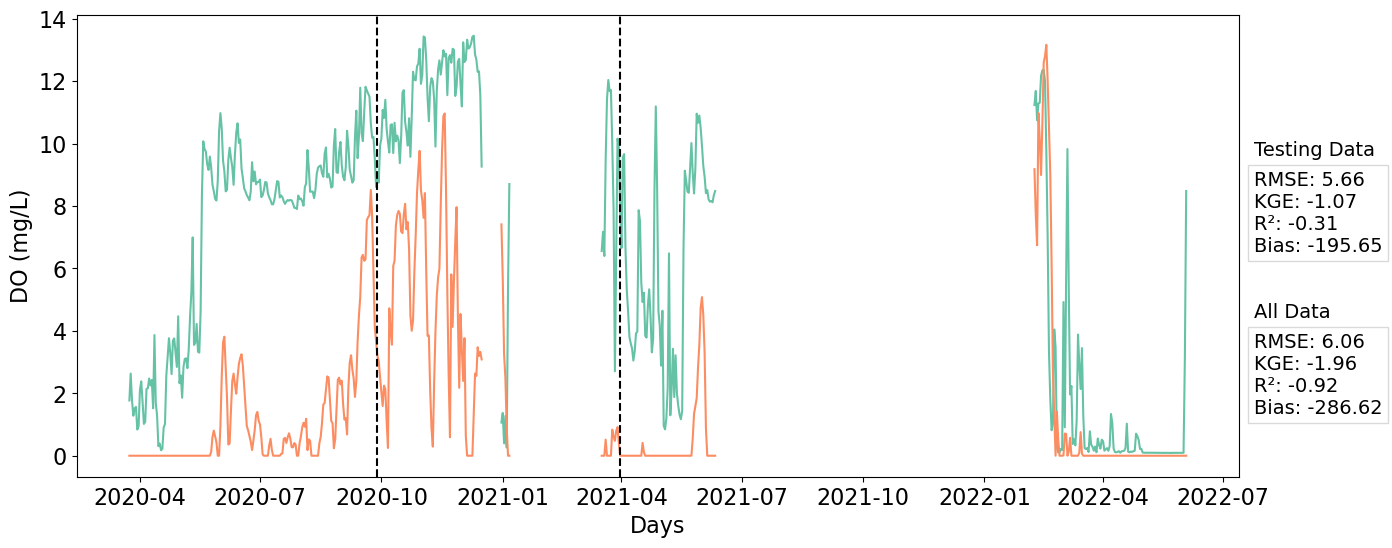

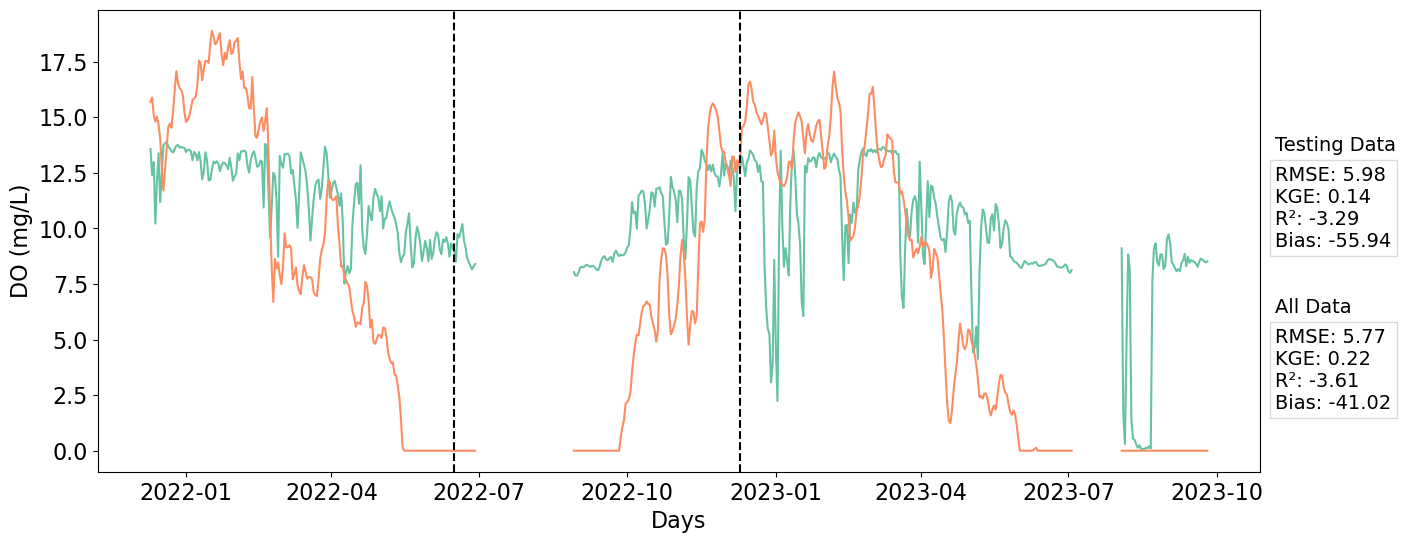

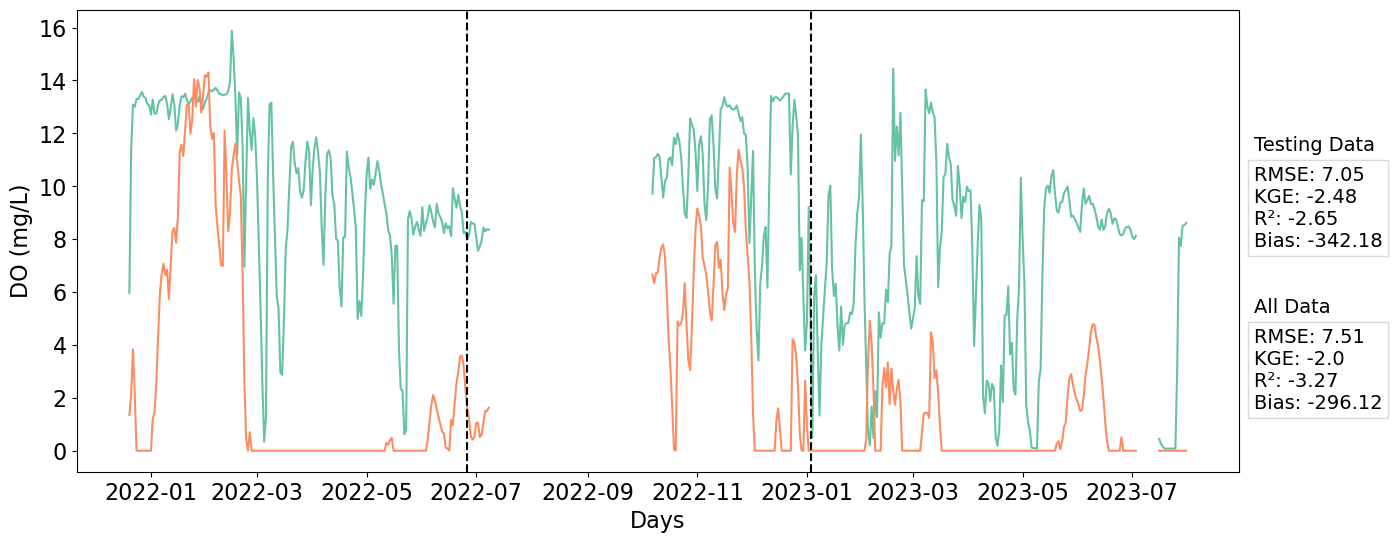

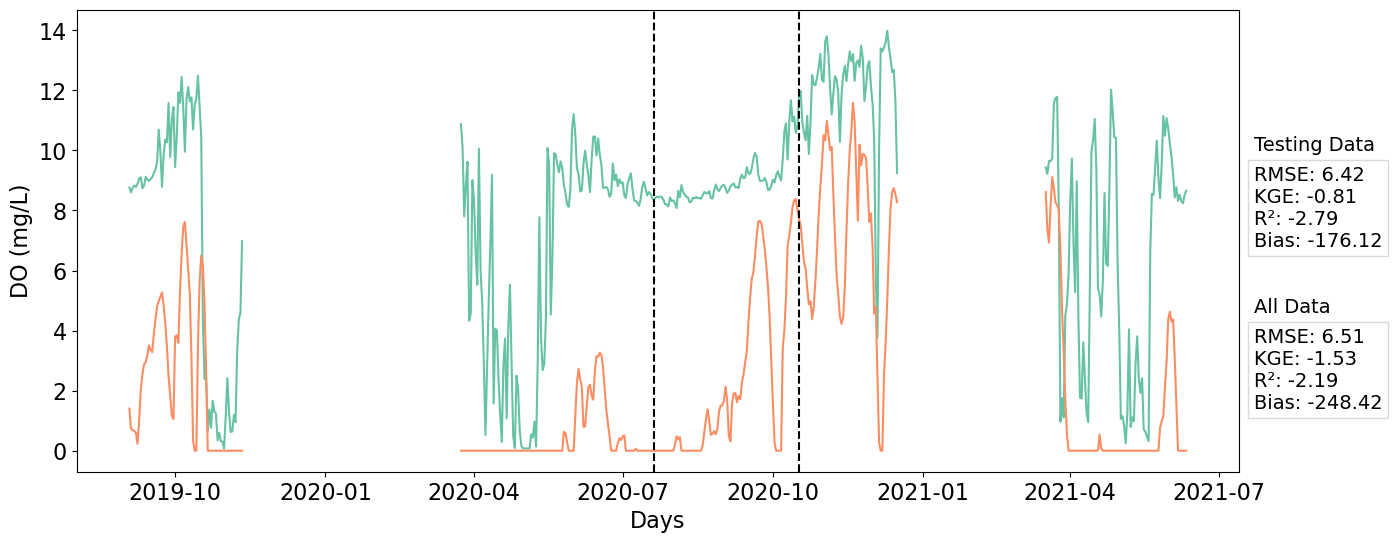

In [16]:
from src.utils import postprocessing as post
from src.utils import logging_setup

OC2_FT_metrics = post.plot_result_sites(y_OC2, OC2_preds, OC2_start, OC2_end, scaler_y, "OC2", FT=True, train=True)
LF1_FT_metrics = post.plot_result_sites(y_LF1, LF1_preds, LF1_start, LF1_end, scaler_y, "LF1", FT=True, train=True)
LF2_FT_metrics = post.plot_result_sites(y_LF2, LF2_preds, LF2_start, LF2_end, scaler_y, "LF2", FT=True, train=True)
OC4_FT_metrics = post.plot_result_sites(y_OC4, OC4_preds, OC4_start, OC4_end, scaler_y, "OC4", FT=True, train=True)
LF3_FT_metrics = post.plot_result_sites(y_LF3, LF3_preds, LF3_start, LF3_end, scaler_y, "LF3", FT=True, train=True)
OC1_FT_metrics = post.plot_result_sites(y_OC1, OC1_preds, OC1_start, OC1_end, scaler_y, "OC1", FT=True, train=True)
OC3_FT_metrics = post.plot_result_sites(y_OC3, OC3_preds, OC3_start, OC3_end, scaler_y, "OC3", FT=True, train=True)